In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from datetime import datetime
import random
from scipy import signal

In [2]:
class Function:
    def __init__(self, start=None, end=None, step=None):
        if start is not None and end is not None and step is not None:
            self.initializeX(start, end, step)
            self.initializeY()
    
    def initializeX(self, start, end, step):
        self.start = start
        self.end = end
        self.step = step
        self.length = int(np.ceil(np.abs(end - start) / step))
        self.X = np.arange(start, end, step)
    
    def initializeY(self):
        self.Y = np.zeros(self.length)
        
    def complex_sin(self, arrA, arrF):
        for i in range(0, len(arrA)):
            self.Y += arrA[i] * np.sin(2 * np.pi * arrF[i] * self.X)
        
    def minus_func(self, arrFunc):
        self.Y = 0
        for i in range(0, len(arrFunc)):
            self.Y -= arrFunc[i].Y.copy()
        
    def trend(self, func):
        L = func.length - self.length
        for m in range(0, self.length):
            sum = 0
            for k in range(m, m + L):
                sum += func.Y[k]
            self.Y[m] = sum / L
            
    def anti_trend(self, func, trend):
        L = func.length - trend.length
        self.X = np.array(list(func.X[:func.length - L]))
        self.Y = np.array(list(func.Y[:func.length - L])) - trend.Y
        self.length = len(self.X)
        
    def fourier_spectrum(self, func, window, freq=False, half=False, dt=1):
        lenZeros = int(func.length * (1 - window) / 2)
        for i in range(0, lenZeros):
            func.Y[i] = 0
            func.Y[N - i - 1] = 0
        sumRe, sumIm = 0, 0
        for k in range(0, func.length):
            sumRe += func.Y[k] * np.cos(2 * np.pi * self.X * k / func.length)
            sumIm += func.Y[k] * np.sin(2 * np.pi * self.X * k / func.length)
        Re = (1 / func.length) * sumRe
        Im = (1 / func.length) * sumIm
        self.Y = (Re ** 2 + Im ** 2) ** 0.5
        if freq:
            # переходим от параметра n к f
            df = 1 / (self.end * dt)
            self.initializeX(self.start, self.end * df, df)
        if half:
            # берём первую половину графика
            self.initializeX(self.start, int(self.end / 2), self.step)
            self.Y = np.array(list(self.Y)[:self.length])
            
    def phase_spectrum(self, func, window, freq=False, half=False, dt=1):
        lenZeros = int(func.length * (1 - window) / 2)
        for i in range(0, lenZeros):
            func.Y[i] = 0
            func.Y[N - i - 1] = 0
        sumRe, sumIm = 0, 0
        for k in range(0, func.length):
            sumRe += func.Y[k] * np.cos(2 * np.pi * self.X * k / func.length)
            sumIm += func.Y[k] * np.sin(2 * np.pi * self.X * k / func.length)
        Re = (1 / func.length) * sumRe
        Im = (1 / func.length) * sumIm
        self.Y = np.arctan(Im / Re)
        if freq:
            # переходим от параметра n к f
            df = 1 / (self.end * dt)
            self.initializeX(self.start, self.end * df, df)
        if half:
            # берём первую половину графика
            self.initializeX(self.start, int(self.end / 2), self.step)
            self.Y = np.array(list(self.Y)[:self.length])
            
    def restore_signal(self, amplitude_spectr, phase_spectr):
        for i in range(0, amplitude_spectr.length):
            self.Y += 2 * amplitude_spectr.Y[i] * np.sin(2 * np.pi * amplitude_spectr.X[i] * self.X + phase_spectr.Y[i])
        
    def read(self, path, enc, date_format):
        self.X = []
        self.Y = []
        with open(path, 'r', encoding=enc) as file:
            for line in file:
                lineSplit = line.split('\t')
                try:
                    self.Y.append(float(lineSplit[1]))
                    date = datetime.strptime(lineSplit[4].replace('\n', ''), date_format)
                    self.X.append(date)
                except:
                    pass
        self.length = len(self.X)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
    
    def convert_to_str(self, attribute):
        if attribute == 'price':
            conv_attr = self.Y
        elif attribute == 'date':
            conv_attr = self.X
        for i in range(0, len(conv_attr)):
            conv_attr[i] = str(conv_attr[i])
            
    def reverse(self):
        self.Y = np.flip(self.Y)
        self.X = np.flip(self.X)
        
    def cut(self, num):
        cut_date = []
        cut_price = []
        for i in range(0, len(self.X)):
            if i % num == 0:
                cut_date.append(self.X[i])
                cut_price.append(self.Y[i])
        self.X = np.array(cut_date)
        self.Y = np.array(cut_price)
        self.length = len(self.X)
    
    def display(self, title, xlabel='x', ylabel='y'):
        plt.plot(self.X, self.Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)
        
class Display:
    @staticmethod
    def show(func, xa, ya, rot=90, title='', xl='', yl=''):
        fig, ax = plt.subplots()
        ax.plot(func.X, func.Y, color='black')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(xa))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(ya))
        plt.xticks(rotation = rot)
        plt.title(title)
        plt.xlabel(xl)
        plt.ylabel(yl)
        fig.set_figwidth(20)
        fig.set_figheight(8)
        plt.grid(True)
        plt.show()
        
    @staticmethod
    def show_func_trend(func, trend, xa, ya, rot=90, title='', xl='', yl=''):
        fig, ax = plt.subplots()
        ax.plot(func.X, func.Y, color='black')
        ax.plot(trend.X, trend.Y, color='red')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(xa))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(ya))
        plt.xticks(rotation = rot)
        plt.title(title)
        plt.xlabel(xl)
        plt.ylabel(yl)
        fig.set_figwidth(20)
        fig.set_figheight(8)
        plt.grid(True)
        plt.show()

def get_A_f(func, threshold):
    A = []
    f = []
    for i in range(1, func.length):
        if func.Y[i] > threshold:
            A.append(func.Y[i] * 2)
            f.append(func.X[i])
    return {'A': A, 'f': f}

In [3]:
class Correlation:
    @staticmethod
    def Rxx(func):
        N = len(func)
        meanF = np.mean(func)
        corr = []
        for l in range(0, N):
            sum1 = 0
            sum2 = 0
            for k in range(0, N - l):
                sum1 += (func[k] - meanF) * (func[k + l] - meanF)
            for k in range(0, N):
                sum2 += (func[k] - meanF) * (func[k] - meanF)
            corr.append(sum1 / sum2)
        return corr

    @staticmethod
    def RxxMean(func):
        N = len(func)
        meanF = np.mean(func)
        corr = []
        for l in range(0, N):
            sum = 0
            for k in range(0, N - l):
                sum += (func[k] - meanF) * (func[k + l] - meanF)
            corr.append(sum / N)
        return corr

    @staticmethod
    def Rxy(func1, func2):
        N = len(func1)
        meanF1 = np.mean(func1)
        meanF2 = np.mean(func2)
        corr = []
        for l in range(0, N):
            sum = 0
            for k in range(0, N - l):
                sum += (func1[k] - meanF1) * (func2[k + l] - meanF2)
            corr.append(sum / N)
        return corr

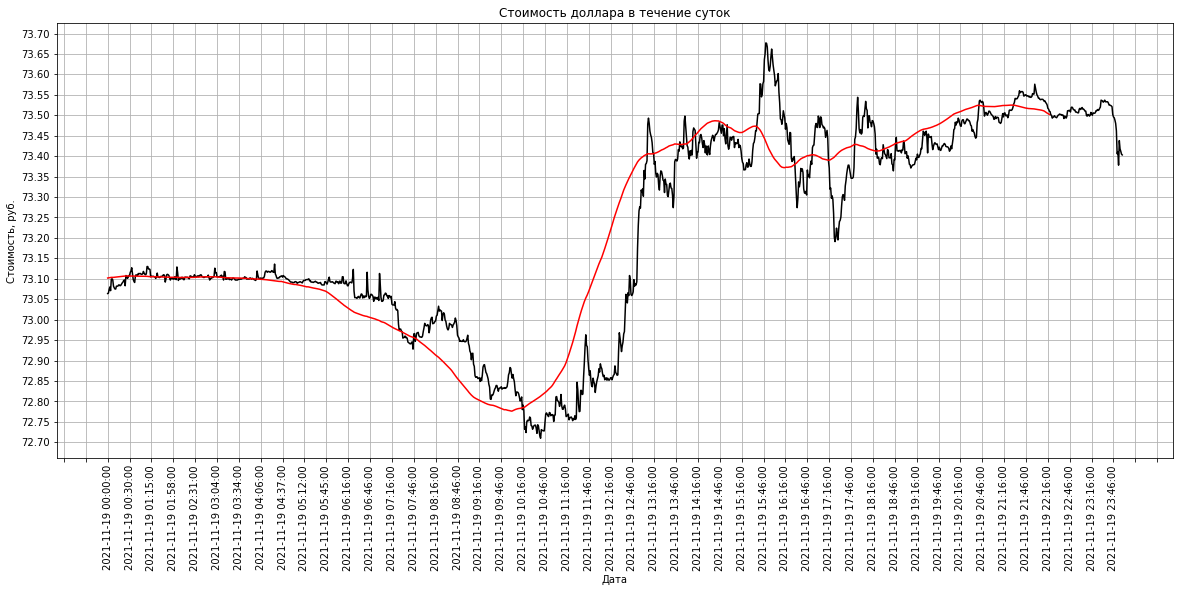

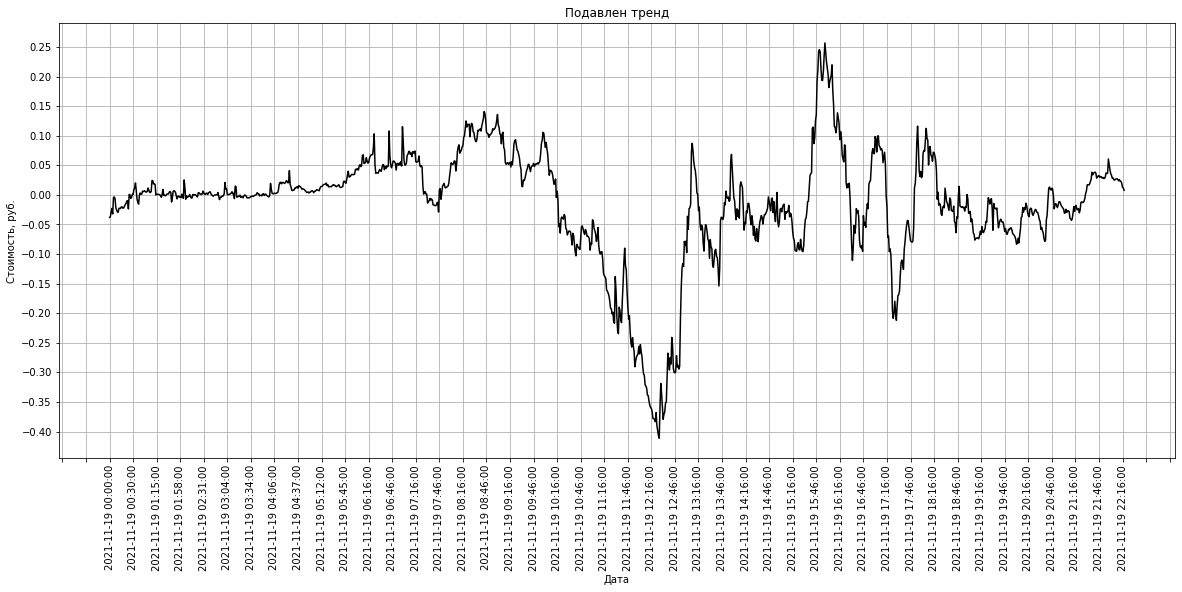

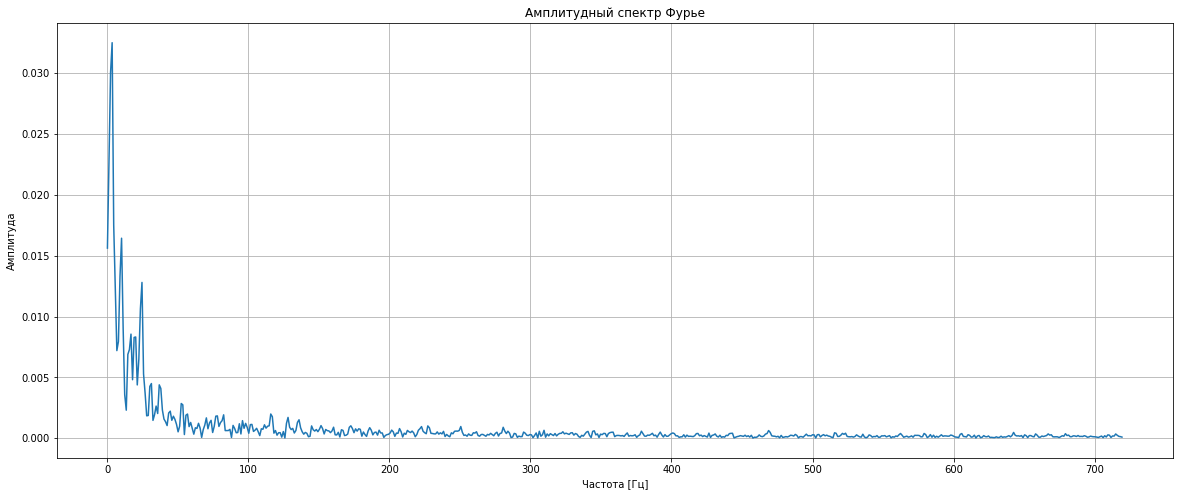

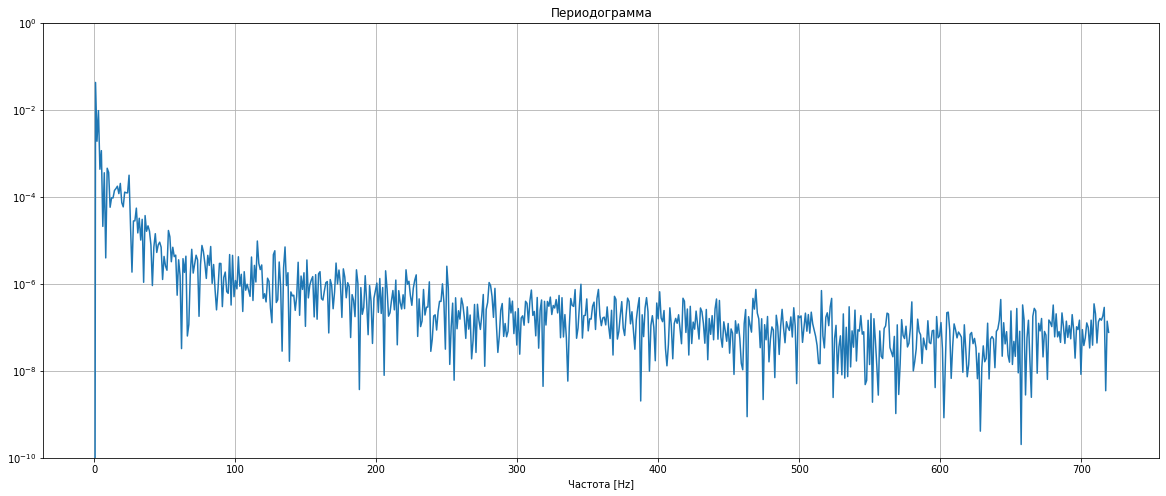

In [4]:
L = 100
start = 0
step = 1
window = 1
dt = 1 / 1440

# Курс доллара поминутно в течение суток
file_1_min = Function()
file_1_min.read('1_min.txt', 'utf-8', "%d.%m.%Y %H:%M")
file_1_min.convert_to_str('date')
file_1_min.reverse()

# Тренд курса доллара
trend = Function(start, file_1_min.length - L, step)
trend.trend(file_1_min)

Display.show_func_trend(file_1_min, trend, 30, 0.05, 90, 'Стоимость доллара в течение суток', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_1_min, trend)

Display.show(anti_trend, 30, 0.05, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(20, 8))
fourier.display('Амплитудный спектр Фурье', 'Частота [Гц]', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)
# plt.figure(figsize=(20, 8))
# phase.display('Фазовый спектр Фурье', 'Частота [Гц]', 'Фаза')

# Периодограмма
plt.figure(figsize=(20, 8))
f, Pxx = signal.periodogram(file_1_min.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-10, 1e0])
plt.title('Периодограмма')
plt.xlabel('Частота [Hz]')
plt.grid(True)
plt.show()

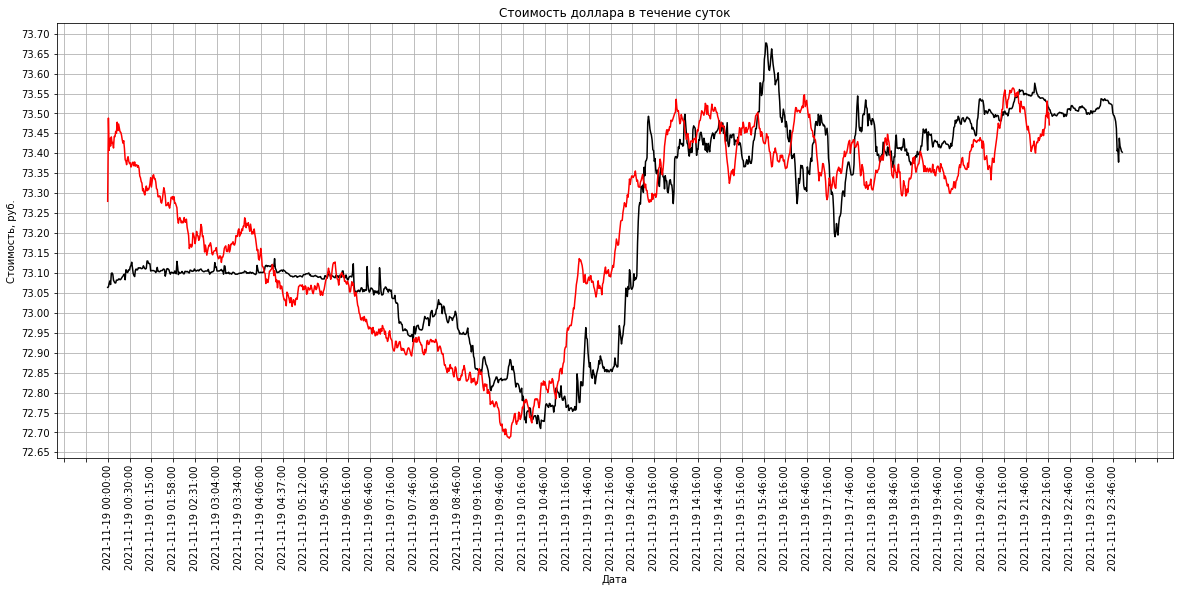

In [5]:
restored = Function(0, file_1_min.length * dt, dt)
restored.restore_signal(fourier, phase)
restored.Y = restored.Y[:restored.length - L] + trend.Y
restored.X = file_1_min.X[:file_1_min.length - L]

Display.show_func_trend(file_1_min, restored, 30, 0.05, 90, 'Стоимость доллара в течение суток', 'Дата', 'Стоимость, руб.')

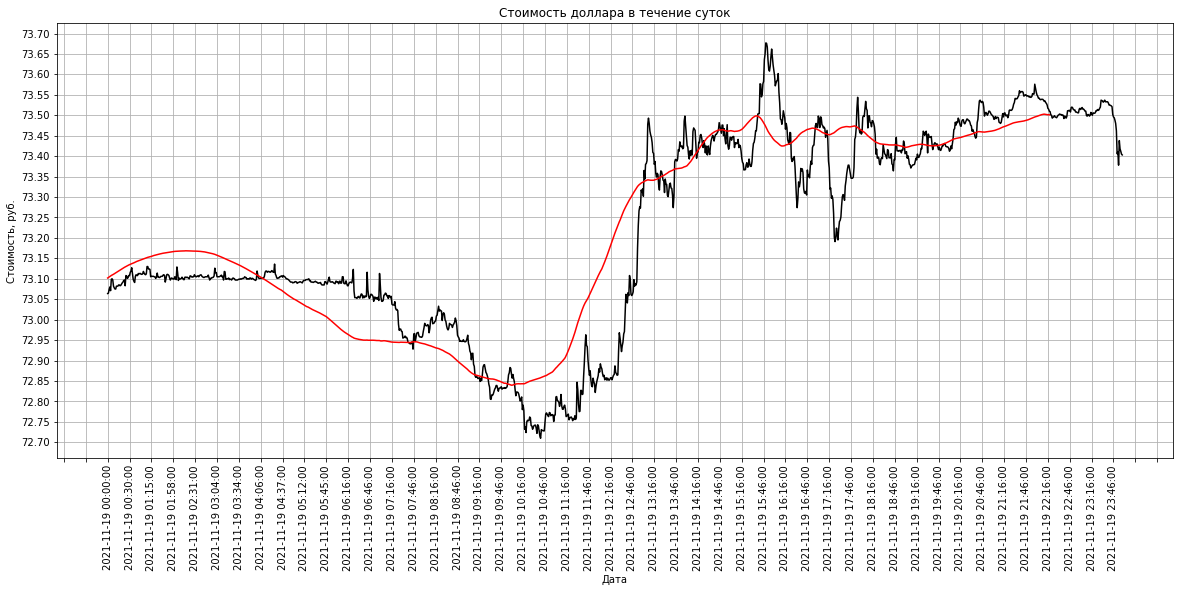

In [6]:
params = get_A_f(fourier, 0.032) # 0.032 - 1 garm, 0.025 - 2, 0.02 - 3, 0.015 - 5
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_1_min, approximation, 30, 0.05, 90, 'Стоимость доллара в течение суток', 'Дата', 'Стоимость, руб.')

In [7]:
arr = np.array([trend.Y, file_1_min.Y[:file_1_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.92178351]
 [0.92178351 1.        ]]


In [8]:
arr = np.array([restored.Y, file_1_min.Y[:file_1_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.        0.8574391]
 [0.8574391 1.       ]]


In [9]:
arr = np.array([approximation.Y, file_1_min.Y[:file_1_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.         0.92087615]
 [0.92087615 1.        ]]


In [10]:
print(params['A'])
print(params['f'])

[0.06501194934242083]
[3.3410672853828305]


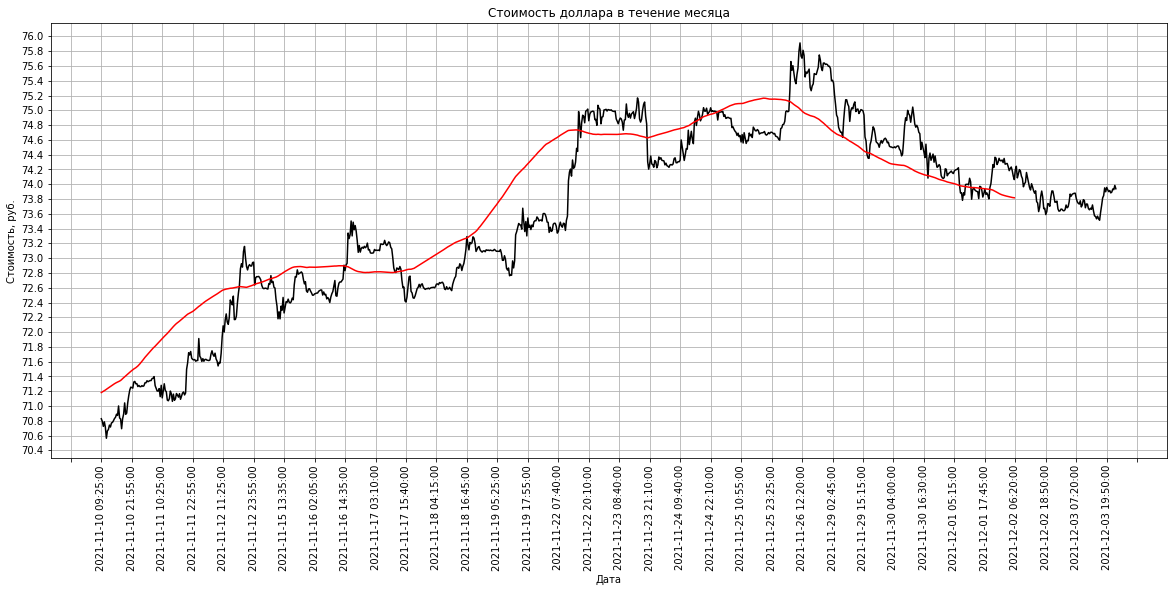

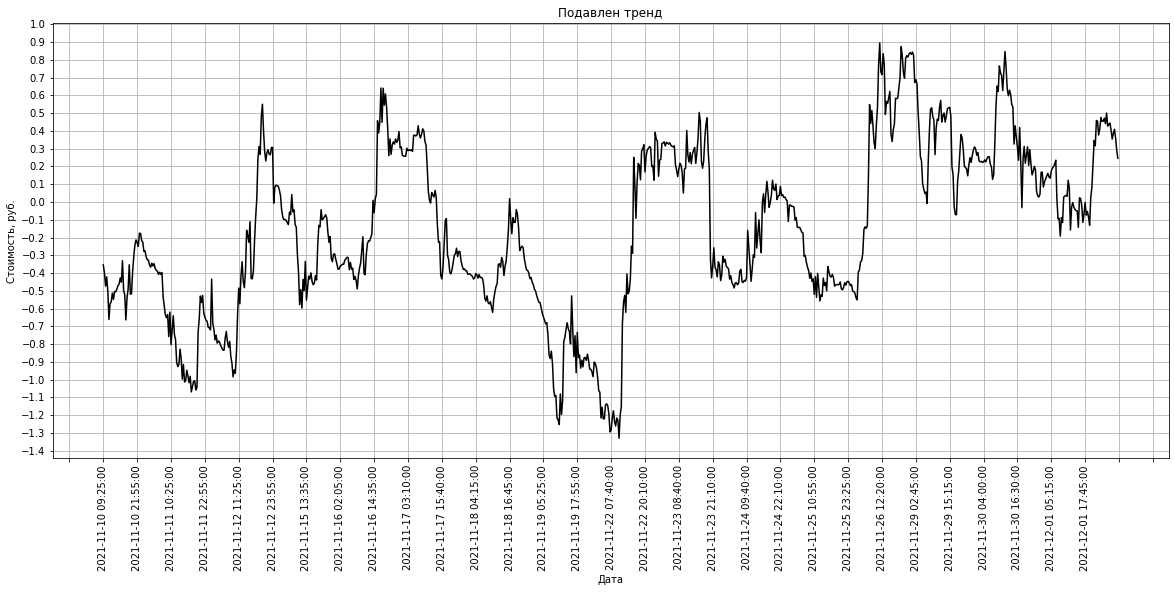

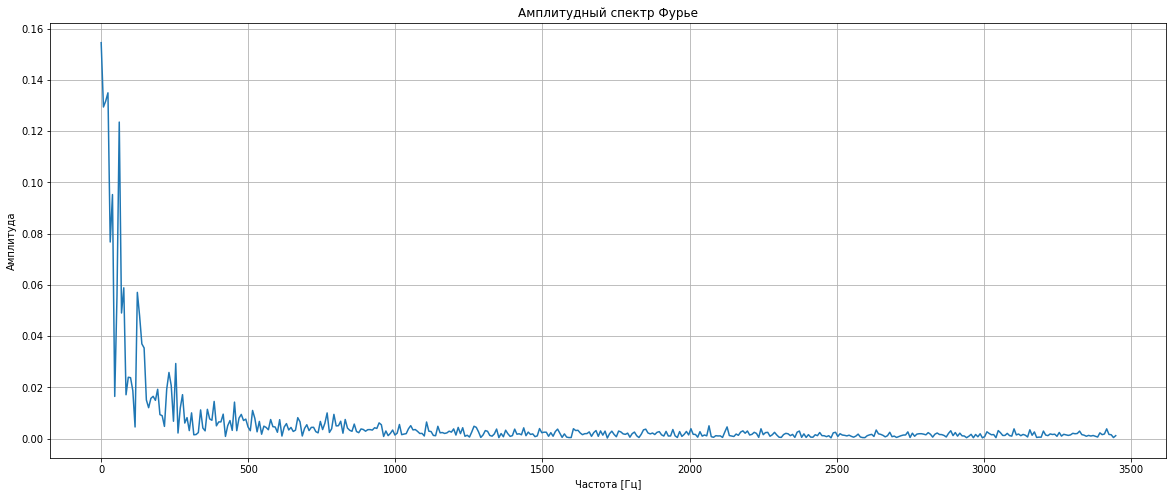

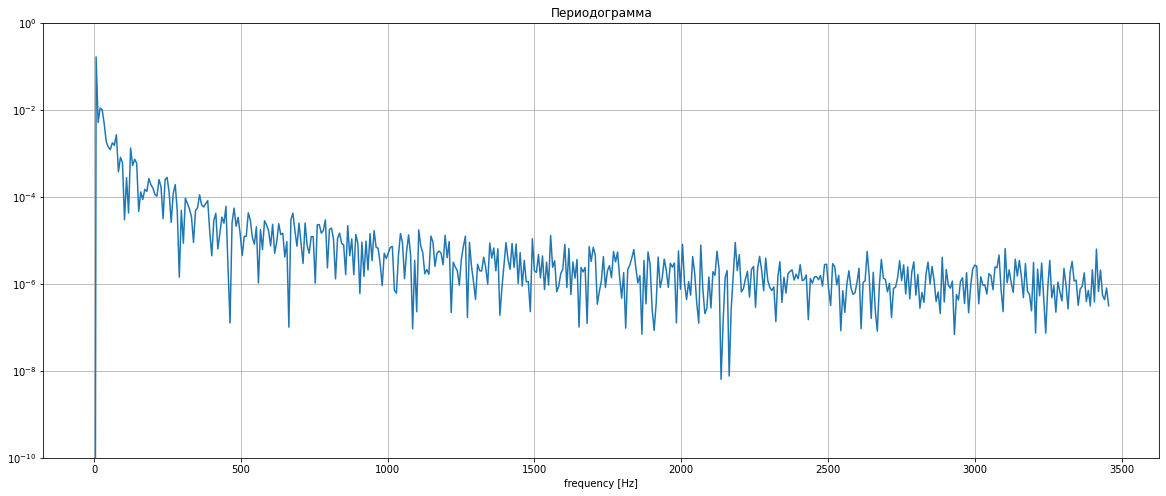

In [11]:
L = 100
start = 0
step = 1
window = 1
dt = 1 / 6912

# Курс доллара поминутно в течение месяца
file_5_min = Function()
file_5_min.read('5_min.txt', 'utf-8', "%d.%m.%Y %H:%M")
file_5_min.convert_to_str('date')
file_5_min.reverse()
file_5_min.cut(5)

# Тренд курса доллара
trend = Function(start, file_5_min.length - L, step)
trend.trend(file_5_min)

Display.show_func_trend(file_5_min, trend, 30, 0.2, 90, 'Стоимость доллара в течение месяца', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_5_min, trend)

Display.show(anti_trend, 30, 0.1, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(20, 8))
fourier.display('Амплитудный спектр Фурье', 'Частота [Гц]', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)
# plt.figure(figsize=(20, 8))
# phase.display('Фазовый спектр Фурье', 'Частота [Гц]', 'Фаза')

# Периодограмма
plt.figure(figsize=(20, 8))
f, Pxx = signal.periodogram(file_5_min.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-10, 1e0])
plt.title('Периодограмма')
plt.xlabel('frequency [Hz]')
plt.grid(True)
plt.show()

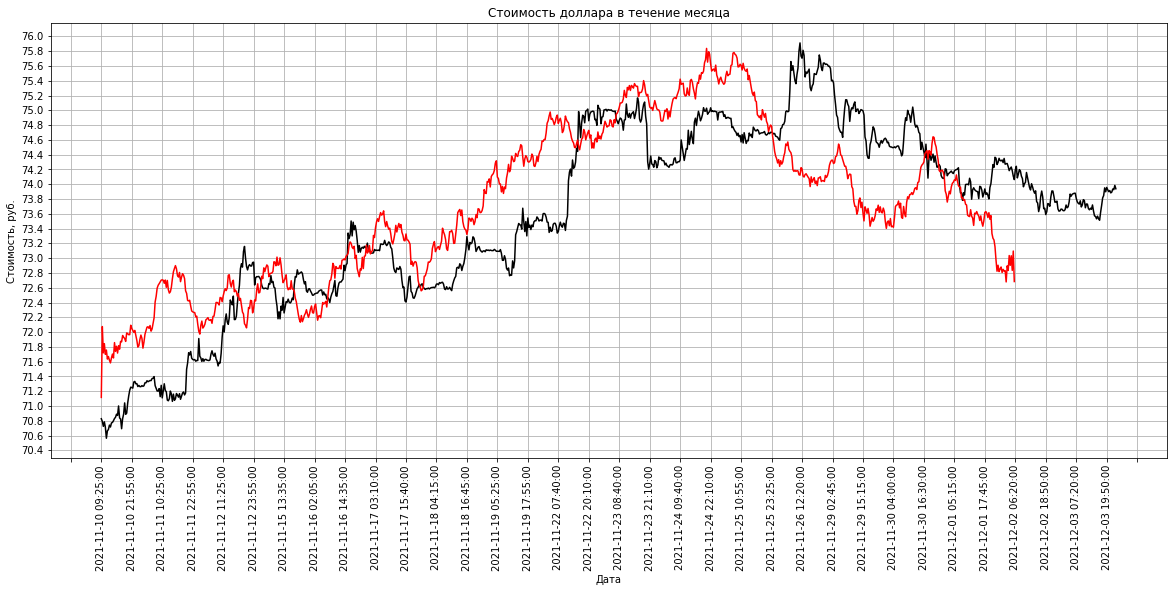

In [12]:
restored = Function(0, file_5_min.length * dt, dt)
restored.restore_signal(fourier, phase)
restored.Y = restored.Y[:restored.length - L - 1] + trend.Y
restored.X = file_5_min.X[:file_5_min.length - L]

Display.show_func_trend(file_5_min, restored, 30, 0.2, 90, 'Стоимость доллара в течение месяца', 'Дата', 'Стоимость, руб.')

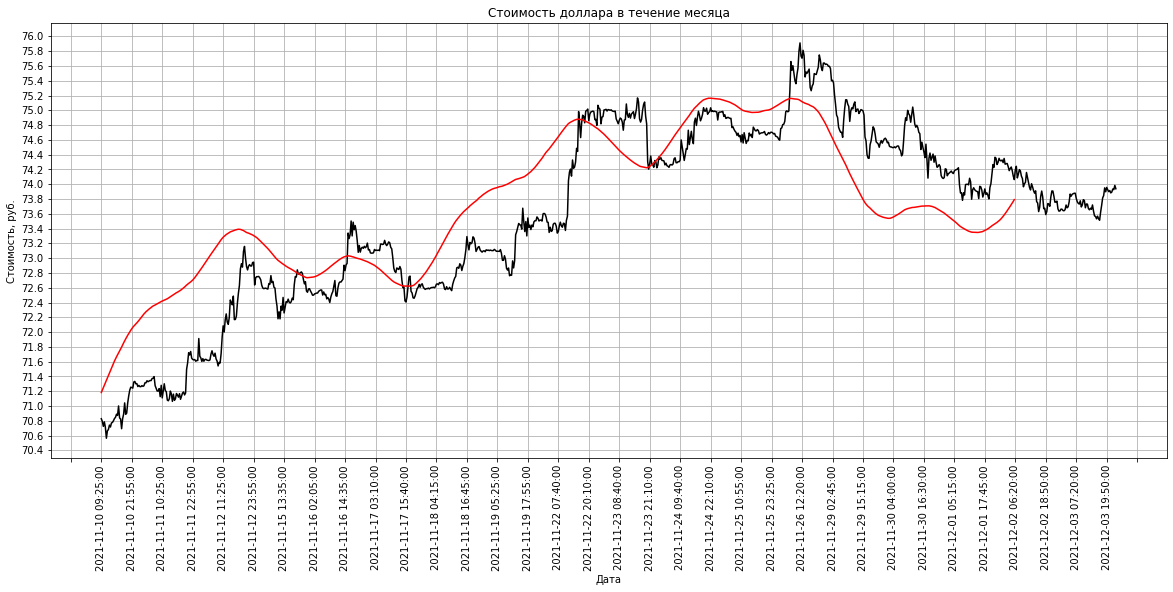

In [13]:
params = get_A_f(fourier, 0.11)
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_5_min, approximation, 30, 0.2, 90, 'Стоимость доллара в течение месяца', 'Дата', 'Стоимость, руб.')

In [14]:
arr = np.array([trend.Y, file_5_min.Y[:file_5_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.93626248]
 [0.93626248 1.        ]]


In [15]:
arr = np.array([restored.Y, file_5_min.Y[:file_5_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.         0.79893813]
 [0.79893813 1.        ]]


In [16]:
arr = np.array([approximation.Y, file_5_min.Y[:file_5_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.         0.85398964]
 [0.85398964 1.        ]]


In [17]:
print(params['A'])
print(params['f'])

[0.2587776350268204, 0.2634053689714492, 0.2698516497297084, 0.24702960987048048]
[7.6800000000000015, 15.360000000000003, 23.040000000000006, 61.44000000000001]


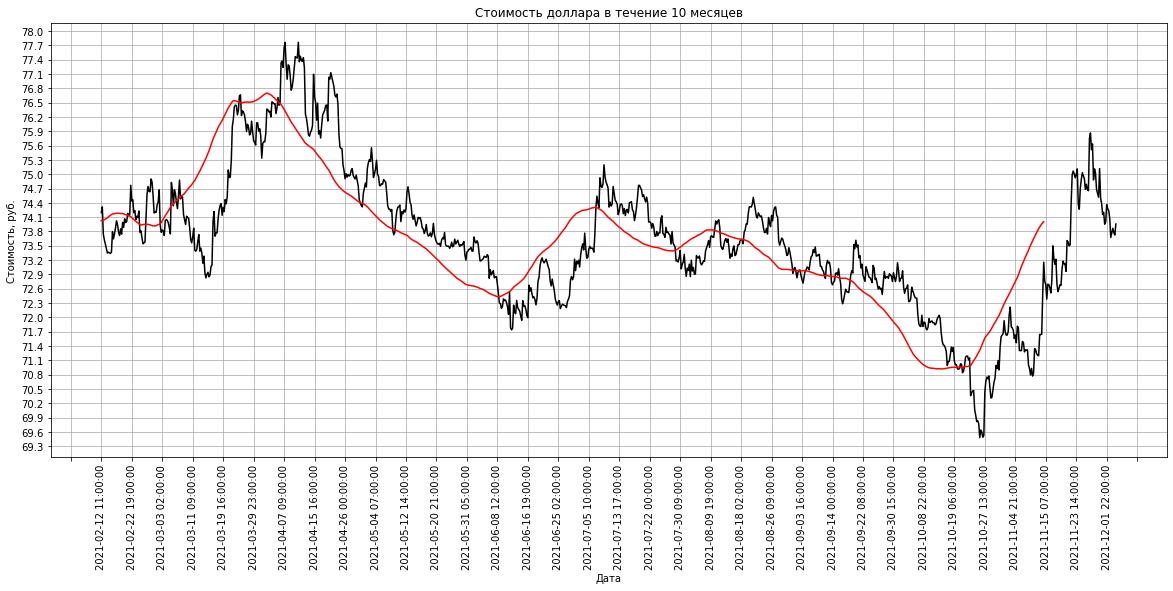

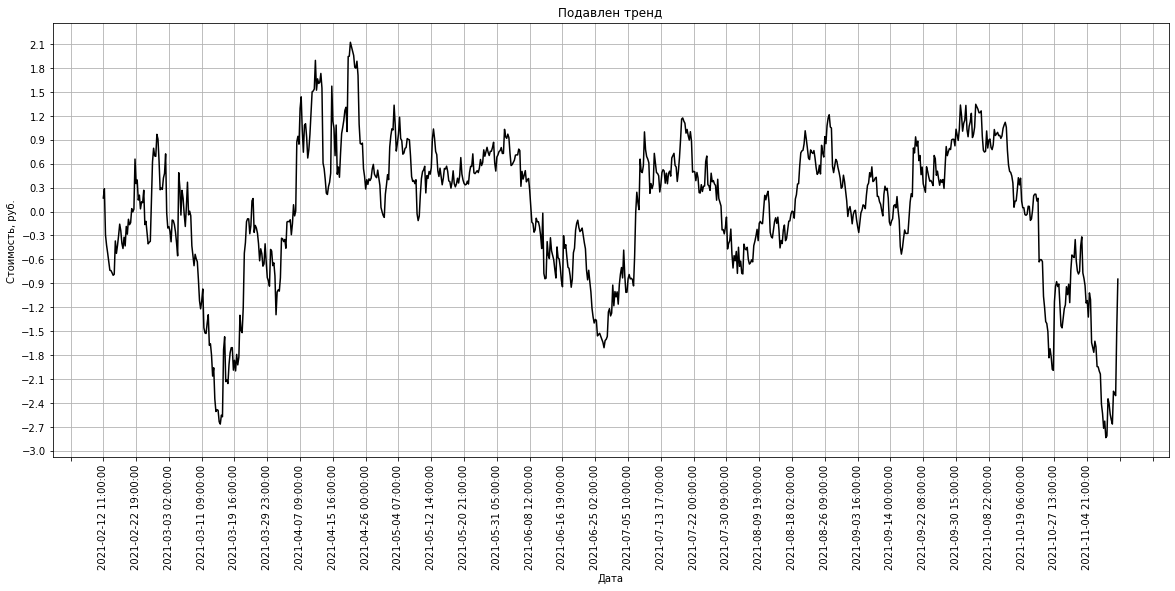

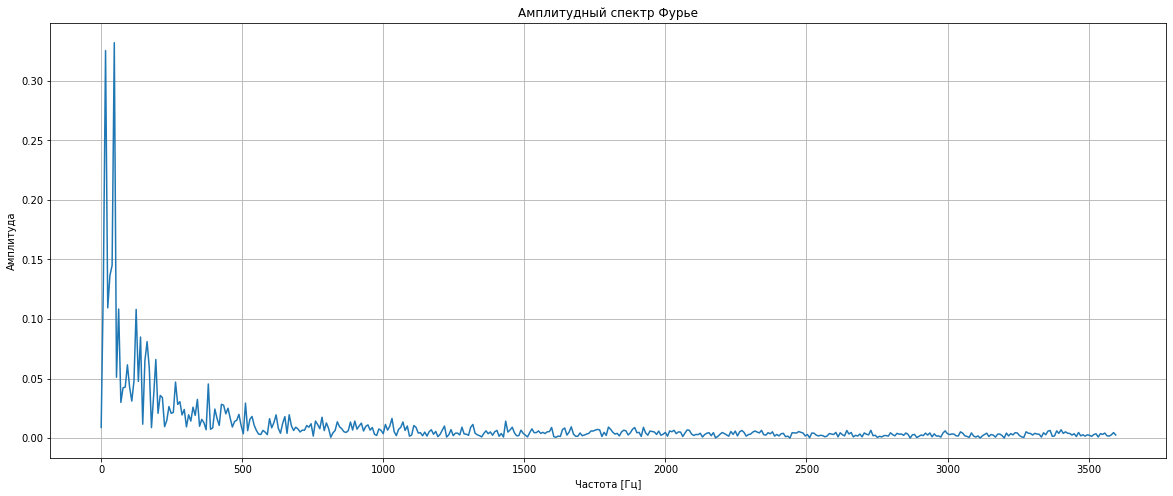

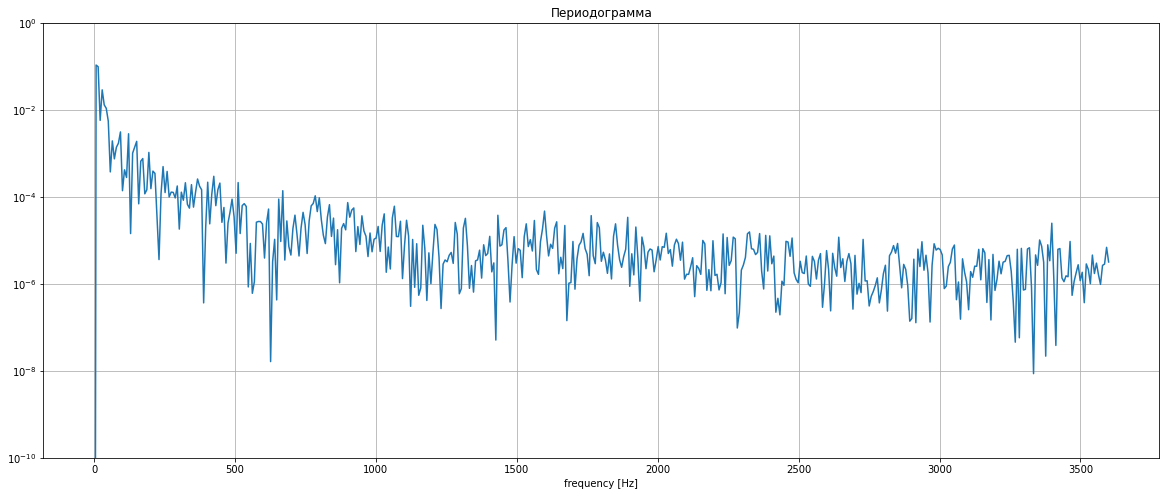

In [18]:
L = 71
start = 0
step = 1
window = 1
dt = 1 / 7200

# Курс доллара поминутно в течение 10 месяцев
file_1_hour = Function()
file_1_hour.read('1_hour.txt', 'utf-8', "%d.%m.%Y %H")
file_1_hour.convert_to_str('date')
file_1_hour.reverse()
file_1_hour.cut(5)

# Тренд курса доллара
trend = Function(start, file_1_hour.length - L, step)
trend.trend(file_1_hour)

Display.show_func_trend(file_1_hour, trend, 30, 0.3, 90, 'Стоимость доллара в течение 10 месяцев', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_1_hour, trend)

Display.show(anti_trend, 30, 0.3, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(20, 8))
fourier.display('Амплитудный спектр Фурье', 'Частота [Гц]', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)
# plt.figure(figsize=(20, 8))
# phase.display('Фазовый спектр Фурье', 'Частота [Гц]', 'Фаза')

# Периодограмма
plt.figure(figsize=(20, 8))
f, Pxx = signal.periodogram(file_1_hour.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-10, 1e0])
plt.title('Периодограмма')
plt.xlabel('frequency [Hz]')
plt.grid(True)
plt.show()

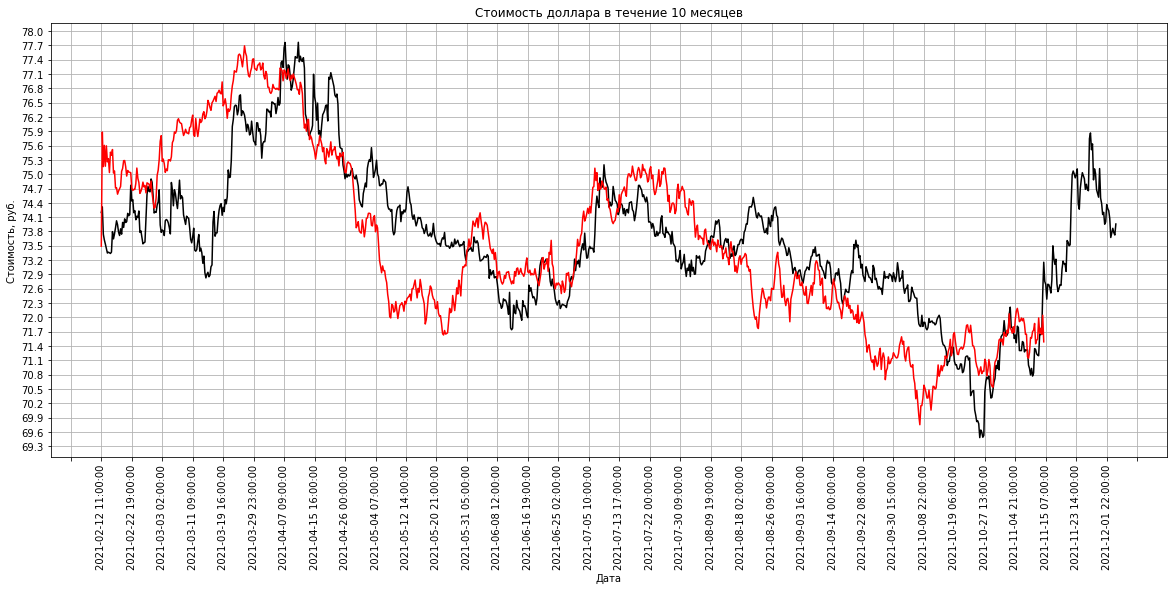

In [19]:
restored = Function(0, file_1_hour.length * dt, dt)
restored.restore_signal(fourier, phase)
restored.Y = restored.Y[:restored.length - L] + trend.Y
restored.X = file_1_hour.X[:file_1_hour.length - L]

Display.show_func_trend(file_1_hour, restored, 30, 0.3, 90, 'Стоимость доллара в течение 10 месяцев', 'Дата', 'Стоимость, руб.')

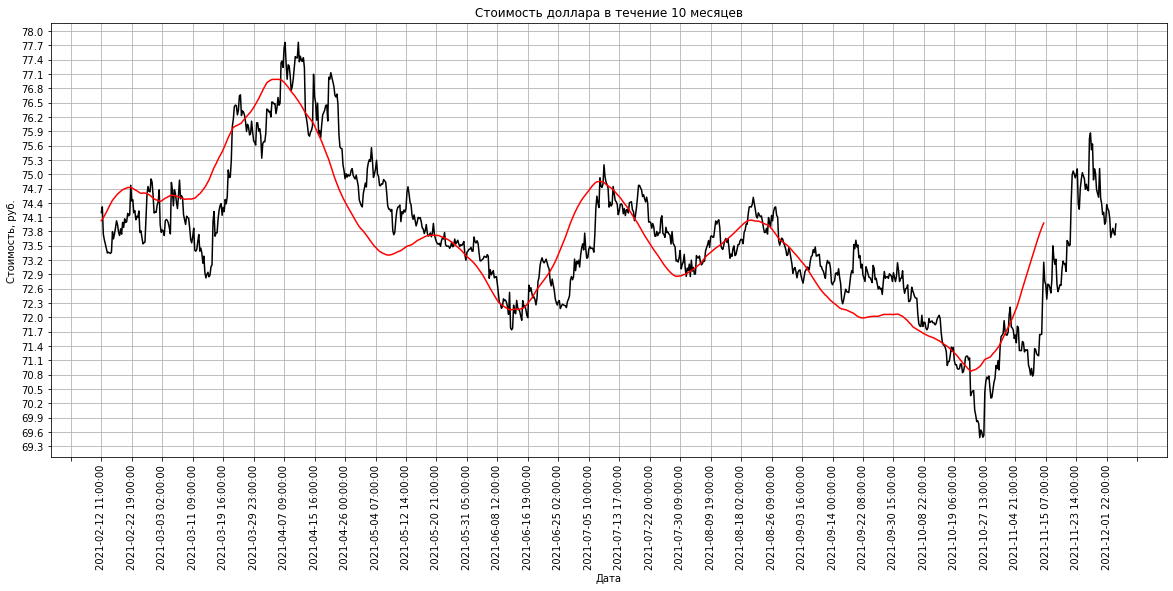

In [20]:
params = get_A_f(fourier, 0.326)
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_1_hour, approximation, 30, 0.3, 90, 'Стоимость доллара в течение 10 месяцев', 'Дата', 'Стоимость, руб.')

In [21]:
arr = np.array([trend.Y, file_1_hour.Y[:file_1_hour.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.81440394]
 [0.81440394 1.        ]]


In [22]:
arr = np.array([restored.Y, file_1_hour.Y[:file_1_hour.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.         0.77386227]
 [0.77386227 1.        ]]


In [23]:
arr = np.array([approximation.Y, file_1_hour.Y[:file_1_hour.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.         0.86567499]
 [0.86567499 1.        ]]


In [24]:
print(params['A'])
print(params['f'])

[0.6638708829120119]
[46.501614639397204]


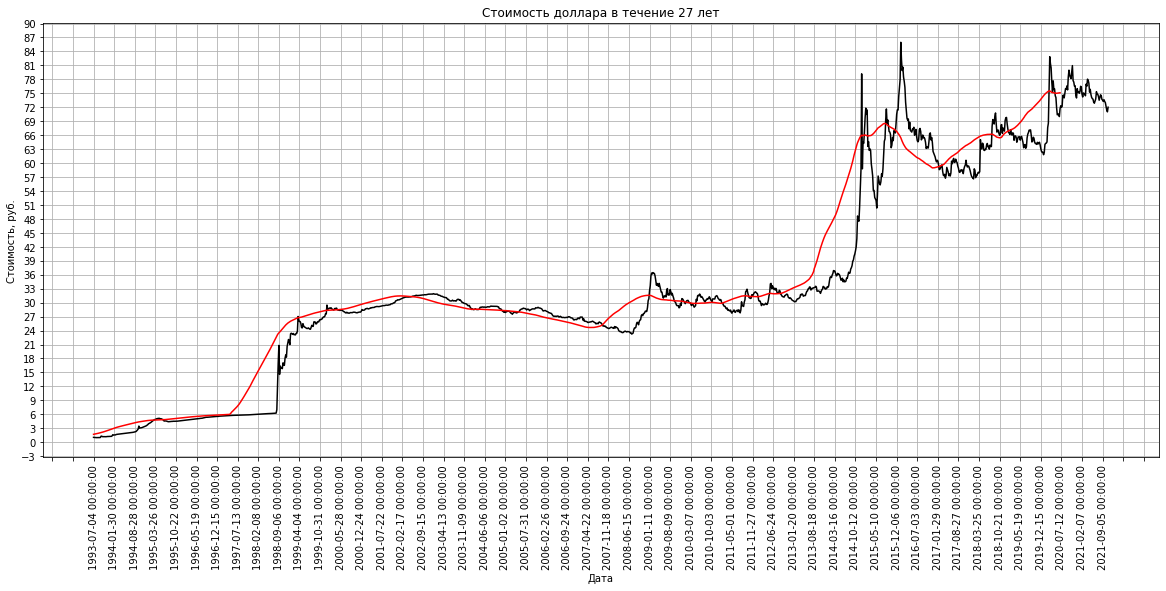

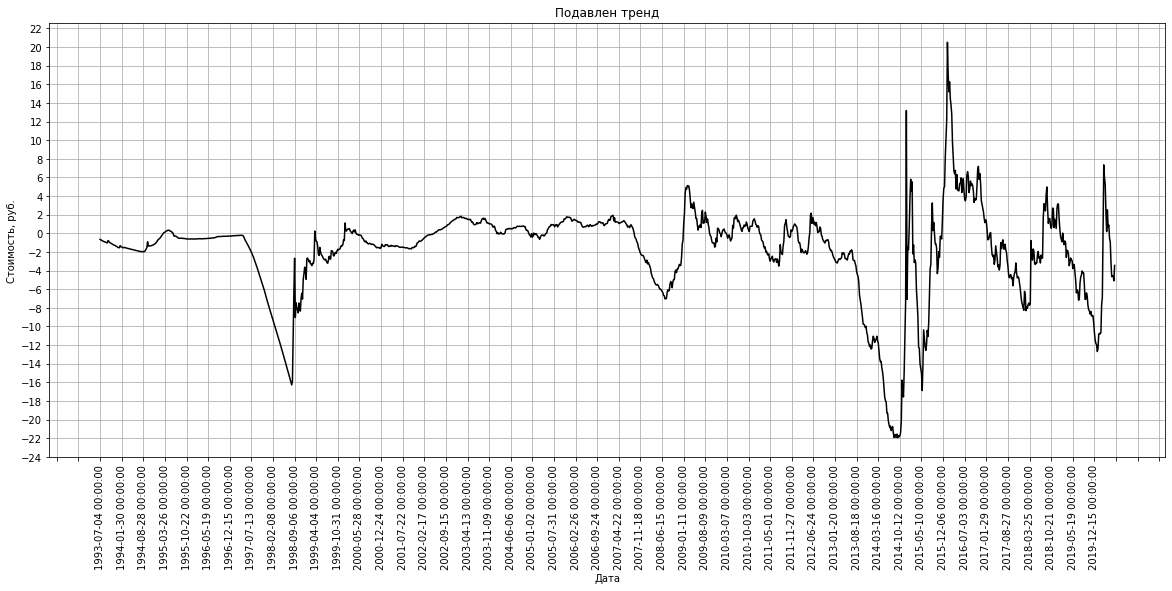

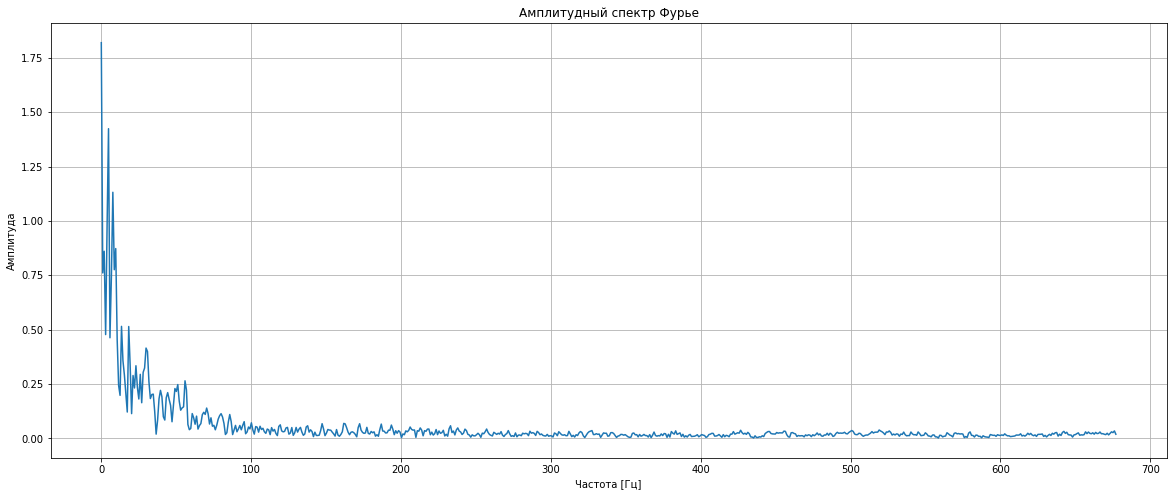

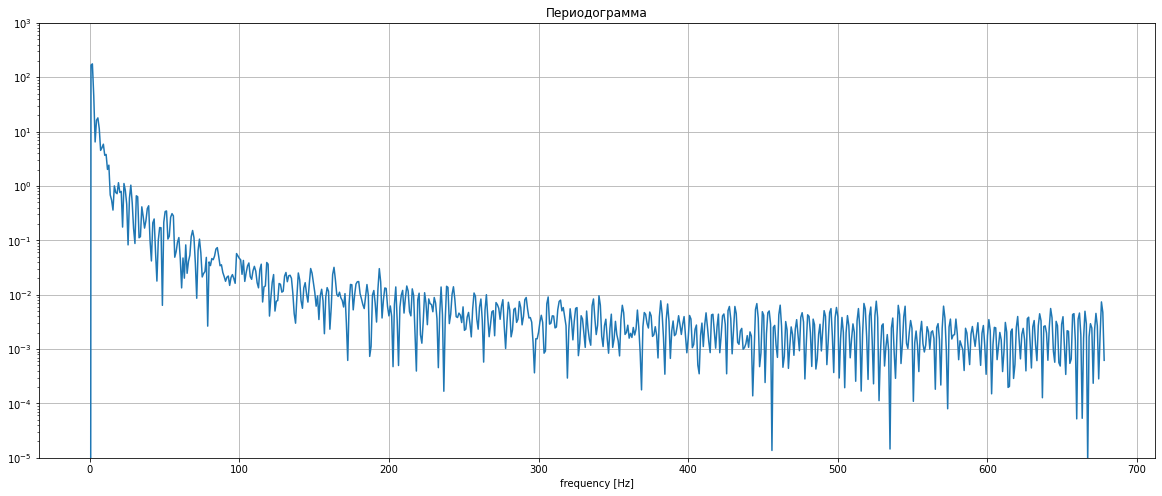

In [25]:
L = 70
start = 0
step = 1
window = 1
dt = 1 / 1357

# Курс доллара поминутно в течение 27 лет
file_1_week = Function()
file_1_week.read('1_week.txt', 'utf-8', "%d.%m.%Y")
file_1_week.convert_to_str('date')
file_1_week.reverse()

# Тренд курса доллара
trend = Function(start, file_1_week.length - L, step)
trend.trend(file_1_week)

Display.show_func_trend(file_1_week, trend, 30, 3, 90, 'Стоимость доллара в течение 27 лет', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_1_week, trend)

Display.show(anti_trend, 30, 2, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(20, 8))
fourier.display('Амплитудный спектр Фурье', 'Частота [Гц]', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)
# plt.figure(figsize=(20, 8))
# phase.display('Фазовый спектр Фурье', 'Частота [Гц]', 'Фаза')

# Периодограмма
plt.figure(figsize=(20, 8))
f, Pxx = signal.periodogram(file_1_week.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-5, 1e3])
plt.title('Периодограмма')
plt.xlabel('frequency [Hz]')
plt.grid(True)
plt.show()

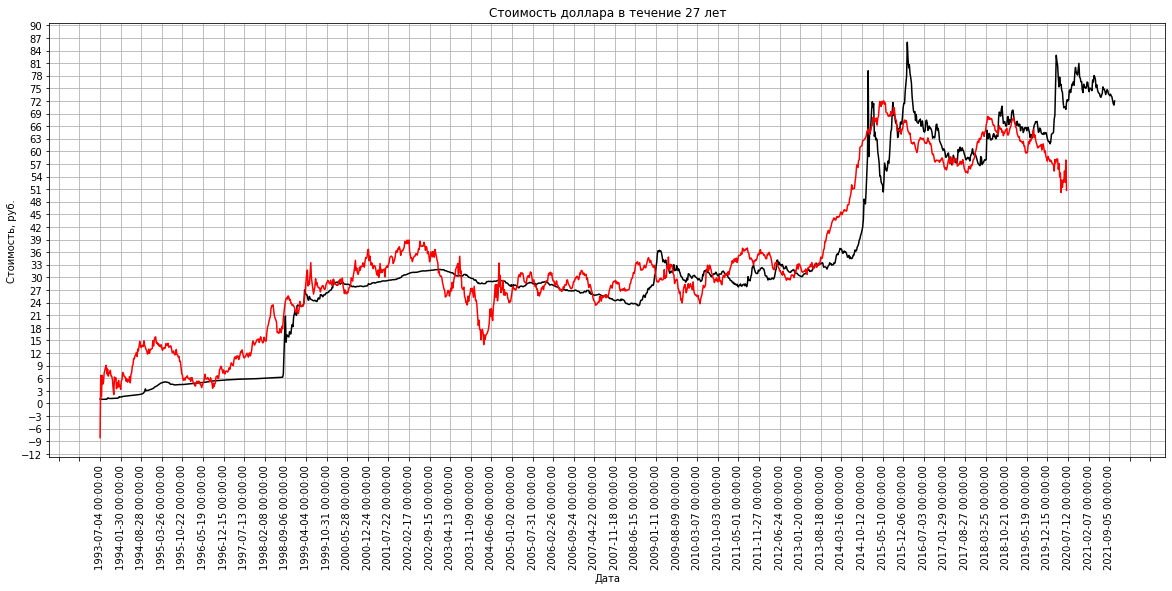

In [26]:
restored = Function(0, file_1_week.length * dt, dt)
restored.restore_signal(fourier, phase)
restored.Y = restored.Y[:restored.length - L] + trend.Y
restored.X = file_1_week.X[:file_1_week.length - L]

Display.show_func_trend(file_1_week, restored, 30, 3, 90, 'Стоимость доллара в течение 27 лет', 'Дата', 'Стоимость, руб.')

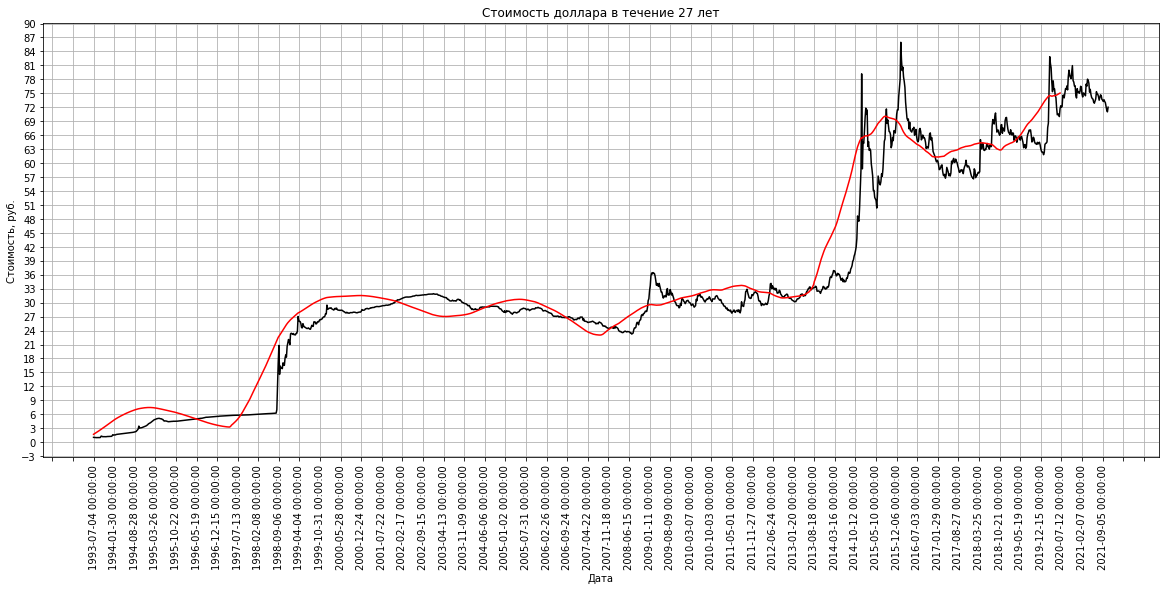

In [27]:
params = get_A_f(fourier, 1.25)
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_1_week, approximation, 30, 3, 90, 'Стоимость доллара в течение 27 лет', 'Дата', 'Стоимость, руб.')

In [28]:
arr = np.array([trend.Y, file_1_week.Y[:file_1_week.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.97028671]
 [0.97028671 1.        ]]


In [29]:
arr = np.array([restored.Y, file_1_week.Y[:file_1_week.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.         0.95116894]
 [0.95116894 1.        ]]


In [30]:
arr = np.array([approximation.Y, file_1_week.Y[:file_1_week.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.         0.97330694]
 [0.97330694 1.        ]]


In [31]:
print(params['A'])
print(params['f'])

[2.8478943159335675]
[4.815471965933286]
